In [1]:
import pandas as pd

df1 = pd.read_csv("0112.csv", encoding="utf-8")
df2 = pd.read_csv("0113.csv", encoding="utf-8")
df3 = pd.read_csv("0114.csv", encoding="utf-8")
df4 = pd.read_csv("0115.csv", encoding="utf-8")
df5 = pd.read_csv("0116.csv", encoding="utf-8")
df6 = pd.read_csv("0117.csv", encoding="utf-8")
df7 = pd.read_csv("0118.csv", encoding="utf-8")
df8 = pd.read_csv("0119.csv", encoding="utf-8")
df9 = pd.read_csv("0120.csv", encoding="utf-8")
df10 = pd.read_csv("0121.csv", encoding="utf-8")
df11 = pd.read_csv("0122.csv", encoding="utf-8")
df12 = pd.read_csv("0123.csv", encoding="utf-8")
df13 = pd.read_csv("0124.csv", encoding="utf-8")
df14 = pd.read_csv("0125.csv", encoding="utf-8")
df15 = pd.read_csv("0126.csv", encoding="utf-8")

In [2]:
df = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15], axis=0, ignore_index = True)
df.shape

(48109, 2)

In [4]:
# 결측치 제거
df = df.dropna(axis = 0)
df.shape

(47497, 2)

In [5]:
# 데이터 중복 유무 확인
df['sentence'].nunique(), df['score'].nunique()

# 중복 제거
df.drop_duplicates(subset=['sentence'], inplace=True)
print('총 샘플 수 :',len(df))

총 샘플 수 : 46668


In [6]:
def rating_to_label(score):
    if score >= 8:
        return 1
    if score <= 4:
        return 0
    
df['y'] = df['score'].apply(lambda x: rating_to_label(x))

In [7]:
df = df.dropna(axis=0).reset_index(inplace=False, drop=True) 
df.shape

(40452, 3)

In [8]:
df["y"].value_counts()

1.0    31558
0.0     8894
Name: y, dtype: int64

In [9]:
text = df['sentence']
score = df['y']

In [10]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(text, score , test_size=0.2, random_state=0)
print(len(train_x), len(train_y), len(test_x), len(test_y))

32361 32361 8091 8091


In [11]:
train_data = pd.concat([train_x, train_y], axis=1).reset_index(inplace=False, drop=True) 
train_data.head()

,sentence,y
0,언제쯤 사랑을 다 알까요. 언제쯤 세상을 다 알까요. 이렇게 살아보면 알까요.,1.0
1,가볍게 즐기기 좋은 영화.액션도 좋았고 배우들의 연기력도 좋았습니다스토리도 나름 괜...,1.0
2,박성훈씨 연기도 잘하고 앞으로가 더 기대되는 배우인데 앞으로 더 좋은 작품을 선택했...,0.0
3,한국 영화계에 뭔가 씌인 것이 분명하다.,0.0
4,뮤덕으로써 제일 처음 본 뮤지컬이 정성화캐슷 영웅이었습니다.정성화씨가 영웅이라는 작...,1.0


In [12]:
test_data = pd.concat([test_x, test_y], axis=1).reset_index(inplace=False, drop=True) 
test_data.head()

,sentence,y
0,대단해요 호중씨가 롱런하길빕니다,1.0
1,로맨스 장르 영화를 자주보지않는데 너무 슬프고 감동적이면서 여운이 많이 남았음...,1.0
2,김운범은 창대를 버리지 말았어야 했다.,1.0
3,1편보다는 재미없지만 평점6.64는 좀그렇네..1.2편다 초딩나이때 3류극장에서 본...,1.0
4,이 내용으로 굳이 피갑칠을 해야 하는가 ㅠㅠ,0.0


In [13]:
print('훈련용 리뷰 개수 :',len(train_data))

훈련용 리뷰 개수 : 32361


In [15]:
print('테스트용 리뷰 개수 :',len(test_data))

테스트용 리뷰 개수 : 8091


<AxesSubplot:>

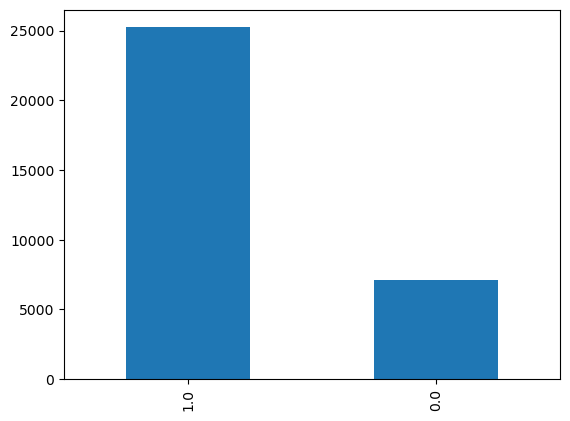

In [19]:
train_data['y'].value_counts().plot(kind = 'bar')

In [20]:
print(train_data.groupby('y').size().reset_index(name = 'count'))

     y  count
0  0.0   7120
1  1.0  25241


In [23]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [26]:
# 한글과 공백을 제외하고 모두 제거
train_data['sentence'] = train_data['sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data.head()

C:\Users\user\AppData\Local\Temp\ipykernel_15096\3914304376.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['sentence'] = train_data['sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,sentence,y
0,언제쯤 사랑을 다 알까요 언제쯤 세상을 다 알까요 이렇게 살아보면 알까요,1.0
1,가볍게 즐기기 좋은 영화액션도 좋았고 배우들의 연기력도 좋았습니다스토리도 나름 괜찮...,1.0
2,박성훈씨 연기도 잘하고 앞으로가 더 기대되는 배우인데 앞으로 더 좋은 작품을 선택했...,0.0
3,한국 영화계에 뭔가 씌인 것이 분명하다,0.0
4,뮤덕으로써 제일 처음 본 뮤지컬이 정성화캐슷 영웅이었습니다정성화씨가 영웅이라는 작품...,1.0


In [27]:
train_data['sentence'] = train_data['sentence'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['sentence'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

sentence    60
y            0
dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_15096\382709517.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['sentence'] = train_data['sentence'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [28]:
train_data.loc[train_data.sentence.isnull()].head()

,sentence,y
251,NaN,1.0
381,NaN,1.0
1276,NaN,1.0
2102,NaN,1.0
2620,NaN,0.0


In [29]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

32301


In [30]:
test_data.drop_duplicates(subset = ['sentence'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['sentence'] = test_data['sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['sentence'] = test_data['sentence'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['sentence'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 8077


C:\Users\user\AppData\Local\Temp\ipykernel_15096\174250314.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['sentence'] = test_data['sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
C:\Users\user\AppData\Local\Temp\ipykernel_15096\174250314.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['sentence'] = test_data['sentence'].str.replace('^ +', "") # 공백은 empty 값으로 변경


## 토큰화

In [31]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [34]:
okt = Okt()

X_train = []
for sentence in tqdm(train_data['sentence']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|███████████████████████████████████████████████████████████████████████████| 32301/32301 [04:22<00:00, 123.03it/s]


In [37]:
print(X_train[:3])

[['언제', '쯤', '사랑', '을', '다', '알다', '요', '언제', '쯤', '세상', '을', '다', '알다', '요', '이렇게', '살', '아보', '면', '알다', '요'], ['가볍다', '즐기다', '좋다', '영화', '액션', '좋다', '배우', '연기력', '좋다', '스토리', '나름', '괜찮다', '것', '같다'], ['박성훈', '씨', '연기', '앞', '으로가', '더', '기대', '되다', '배우', '인데', '앞', '더', '좋다', '작품', '을', '선택', '좋다']]


In [38]:
X_test = []
for sentence in tqdm(test_data['sentence']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████████| 8077/8077 [01:18<00:00, 102.65it/s]


## 정수 인코딩

In [39]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [40]:
print(tokenizer.word_index)

{'보다': 1, '영화': 2, '을': 3, '너무': 4, '좋다': 5, '이다': 6, '있다': 7, '재밌다': 8, '없다': 9, '연기': 10, '감동': 11, '되다': 12, '배우': 13, '적': 14, '같다': 15, '로': 16, '다': 17, '스토리': 18, '에서': 19, '진짜': 20, '만': 21, '않다': 22, '생각': 23, '것': 24, '그': 25, '나오다': 26, '아니다': 27, '자다': 28, '더': 29, '정말': 30, '안': 31, '만들다': 32, '최고': 33, '가다': 34, '시간': 35, '연출': 36, '수': 37, '보고': 38, '인': 39, '고': 40, '나': 41, '님': 42, '사람': 43, '재미있다': 44, '게': 45, '평점': 46, '때': 47, '내': 48, '하고': 49, '왜': 50, '들다': 51, '요': 52, '볼': 53, '그냥': 54, '까지': 55, '꼭': 56, '모르다': 57, '감독': 58, '못': 59, '싶다': 60, '눈물': 61, '장면': 62, '다시': 63, '점': 64, '말': 65, '오다': 66, '내용': 67, '마지막': 68, '이렇다': 69, '정도': 70, '슬램덩크': 71, '많다': 72, '액션': 73, '아쉽다': 74, '그렇다': 75, '알다': 76, '작품': 77, '느낌': 78, '처음': 79, 'ㅠㅠ': 80, '저': 81, '많이': 82, '기대': 83, '분': 84, '하나': 85, '중': 86, '느끼다': 87, '재미': 88, '영': 89, '부터': 90, '노래': 91, '몰입': 92, '거': 93, '추천': 94, '지루하다': 95, '번': 96, '또': 97, '이야기': 98, '아깝다': 99, '아': 100, '영상': 101, '넘다': 102

In [41]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 19317
등장 빈도가 2번 이하인 희귀 단어의 수: 10981
단어 집합에서 희귀 단어의 비율: 56.84630118548429
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.7178156822098805


In [42]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 8337


In [43]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [44]:
print(X_train[:3])

[[536, 591, 114, 3, 17, 76, 52, 536, 591, 444, 3, 17, 76, 52, 108, 295, 5344, 150, 76, 52], [526, 708, 5, 2, 73, 5, 13, 213, 5, 18, 351, 162, 24, 15], [331, 10, 316, 4158, 29, 83, 12, 13, 115, 316, 29, 5, 77, 3, 541, 5]]


In [45]:
y_train = np.array(train_data['y'])
y_test = np.array(test_data['y'])

## 빈 샘플(empty samples) 제거

In [46]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [47]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

32285
32285


C:\Users\user\.conda\envs\geopandas\lib\site-packages\numpy\lib\function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


## 패딩

리뷰의 최대 길이 : 314
리뷰의 평균 길이 : 15.08824531516184


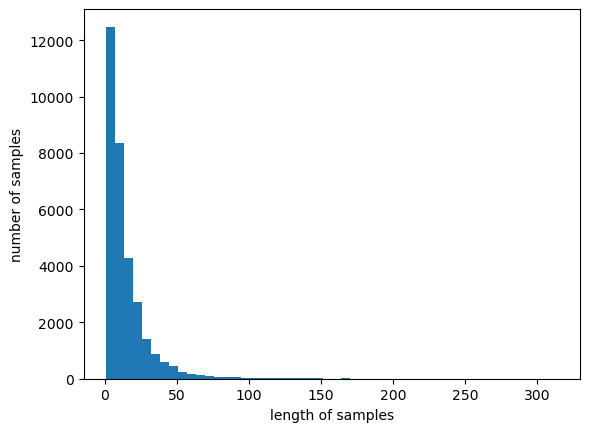

In [48]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [49]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [51]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 96.49372773733931


In [52]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

## LSTM으로 네이버 영화 리뷰 감성 분류하기

In [53]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
403/404 [============================>.] - ETA: 0s - loss: 0.3511 - acc: 0.8524
Epoch 1: val_acc improved from -inf to 0.88818, saving model to best_model.h5
404/404 [==============================] - 28s 64ms/step - loss: 0.3508 - acc: 0.8525 - val_loss: 0.2644 - val_acc: 0.8882
Epoch 2/15
403/404 [============================>.] - ETA: 0s - loss: 0.2348 - acc: 0.9075
Epoch 2: val_acc improved from 0.88818 to 0.89887, saving model to best_model.h5
404/404 [==============================] - 27s 66ms/step - loss: 0.2348 - acc: 0.9075 - val_loss: 0.2523 - val_acc: 0.8989
Epoch 3/15
403/404 [============================>.] - ETA: 0s - loss: 0.2063 - acc: 0.9204
Epoch 3: val_acc improved from 0.89887 to 0.90181, saving model to best_model.h5
404/404 [==============================] - 26s 64ms/step - loss: 0.2061 - acc: 0.9205 - val_loss: 0.2499 - val_acc: 0.9018
Epoch 4/15
403/404 [============================>.] - ETA: 0s - loss: 0.1944 - acc: 0.9275
Epoch 4: val_acc did not im

In [54]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

253/253 [==============================] - 3s 10ms/step - loss: 0.2552 - acc: 0.9022

 테스트 정확도: 0.9022


In [55]:
with open('tokenizer.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle)

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

## 리뷰 예측해보기

In [67]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))
    
sentiment_predict(input('감성분석할 문장을 입력해 주세요.: '))

감성분석할 문장을 입력해 주세요.:  오랜만에 좋은 영화 보다 갑니다


1/1 [==============================] - 0s 90ms/step
98.47% 확률로 긍정 리뷰입니다.

